In [8]:
# !unzip -q '/content/drive/MyDrive/Colab Notebooks/datasets/Trees/TreeDataV4/TreeDatav4.zip' -d './data'

## Imports

In [9]:
import os

from PIL import Image
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset


## Dataset

In [10]:
# Loading Dataset
class TreeSegmentationDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        
        self.BASEDIR = './data'
        self.FOLDER = f"{self.BASEDIR}/TreeDatav4"
        self.image_idx = os.listdir(f"{self.FOLDER}/Images/")
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        image_name = self.image_idx[idx]
        img = read_image(f"{self.FOLDER}/Images/{image_name}", mode=ImageReadMode.RGB) / 255 

        seg_with_alpha = read_image(f"{self.FOLDER}/Seg/{image_name}", mode=ImageReadMode.GRAY_ALPHA) / 255
        seg = torch.where(seg_with_alpha[1] > 0.5, torch.tensor(1), torch.tensor(0)).unsqueeze(0)

        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)

        if self.target_transform:
            seg = self.target_transform(seg)
            
        return img, seg

In [11]:
# Variables
EPOCHS = 20
BATCH_SIZE = 32
SHUFFLE=True
NUM_WORKERS = 2
LEARNING_RATE = 1e-3

SAVING = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

if DEVICE == 'cuda':
    device_name = torch.cuda.get_device_name(0)
    print(f"Setting compute device to {DEVICE} on {device_name}")

Setting compute device to cuda on Tesla T4


In [12]:
transform = None
# Create Base test and train datasets
dataset_normal = TreeSegmentationDataset(transform=transform)

transform = transforms.Compose([
    transforms.RandomRotation(30), 
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1)
])
# Create Augmented Dataset
dataset_augmented = TreeSegmentationDataset(transform=transform)

# Merge the normal and augmented datasets
dataset = ConcatDataset([dataset_normal, dataset_augmented])

# Split the dataset into test and training data 80:20 split
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [13]:
# Load train dataset
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
print(f"Length of training dataset is: {len(dataloader) * BATCH_SIZE}")

Length of training dataset is: 8320


In [14]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(10,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.axis(False)
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image.permute(1,2,0), cmap='gray')
    plt.show()

Length of train dataset: 8320
Shape of Image: torch.Size([3, 200, 200])
Shape of Segmentation mask: torch.Size([1, 200, 200])


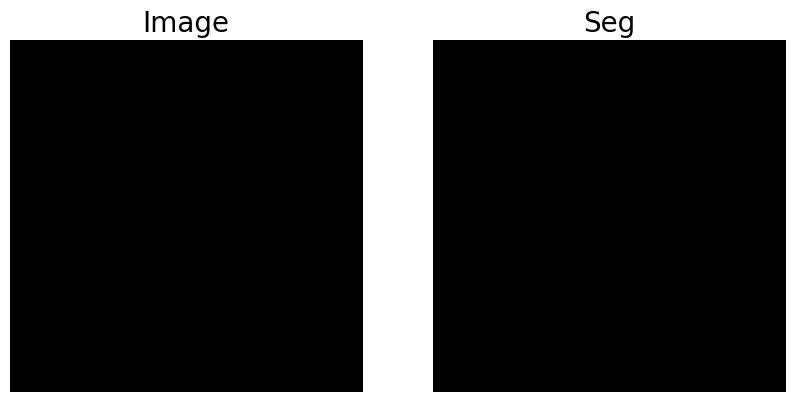

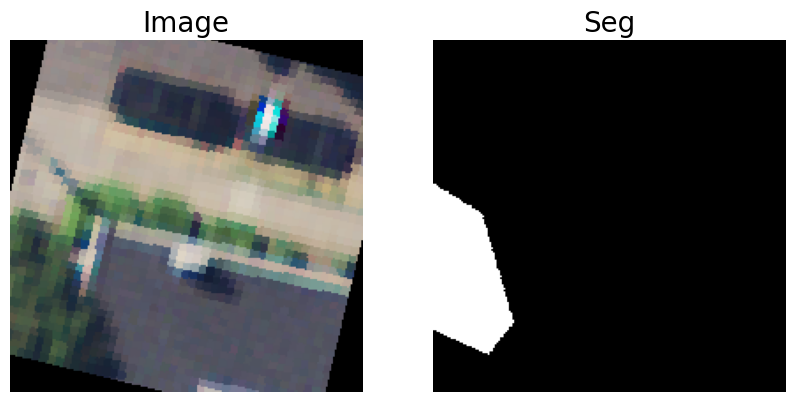

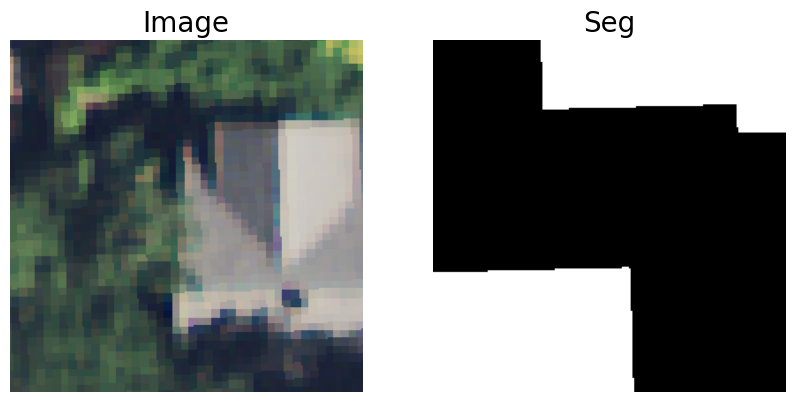

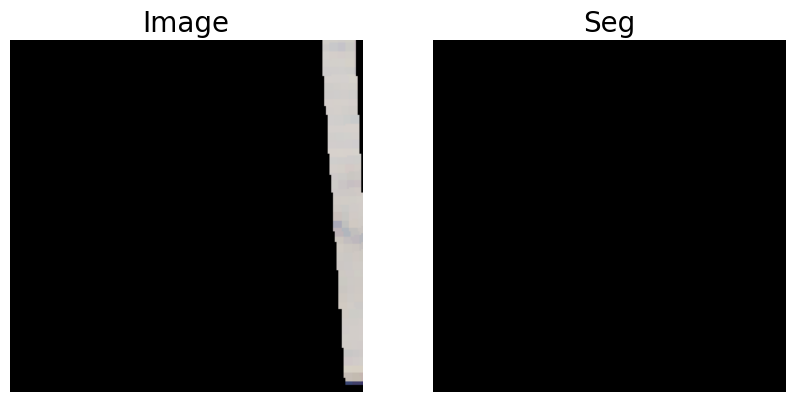

In [15]:
image, seg = next(iter(dataloader))
print(f"Length of train dataset: {len(dataloader) * BATCH_SIZE}")
print(f"Shape of Image: {image[0].shape}")
print(f"Shape of Segmentation mask: {seg[0].shape}")
images_to_display = 4
for image, seg in dataloader:
    visualize(image=image[0], seg=seg[0])
    images_to_display -= 1
    if images_to_display == 0:
        break

In [16]:
image.min(), image.max(), seg.min(), seg.max()

(tensor(0.), tensor(0.9137), tensor(0), tensor(1))

## Model Initialization 

In [17]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, kernal_size=2):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=kernal_size, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        self.b = conv_block(512, 1024)
        self.d1 = decoder_block(1024, 512, kernal_size=3)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        outputs = self.outputs(d4)
        return outputs

In [18]:
if DEVICE == 'cuda':
    torch.cuda.empty_cache()
model = UNet().to(DEVICE)

In [19]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params:,}")

Number of trainable parameters are: 33,664,961


In [20]:
# Loss Function 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [21]:
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training 

In [22]:
def train(
    model=model,
    dataloader=dataloader,
    criterion=criterion, 
    optimizer=optimizer,
    device=DEVICE,
    epochs=EPOCHS
):
    model.train() # Set the model in training mode
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0
        n_batch = 0
        print(f"Epoch: {epoch + 1}/{epochs}")
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        epoch_loss = running_loss / n_batch
        loss_list.append(epoch_loss)
        
        print(f"Training Loss {epoch_loss:.6f}")
    
    return loss_list

In [23]:
losses = train(model)

Epoch: 1/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.283542
Epoch: 2/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.260894
Epoch: 3/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.258448
Epoch: 4/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.254424
Epoch: 5/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.252106
Epoch: 6/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.248806
Epoch: 7/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.248261
Epoch: 8/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.246640
Epoch: 9/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.245673
Epoch: 10/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.244248
Epoch: 11/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.241934
Epoch: 12/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.242982
Epoch: 13/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.241814
Epoch: 14/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.240177
Epoch: 15/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.239762
Epoch: 16/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.238699
Epoch: 17/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.237813
Epoch: 18/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.236860
Epoch: 19/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.237639
Epoch: 20/20


  0%|          | 0/260 [00:00<?, ?it/s]

Training Loss 0.236310


Text(0, 0.5, 'Loss')

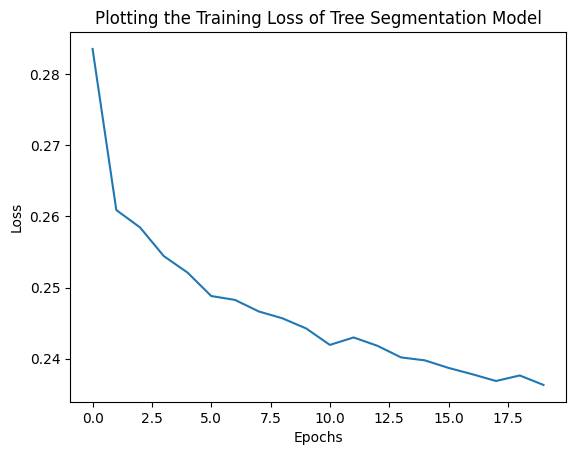

In [24]:
# Plot the loss curve
plt.plot(losses)

# sns.despine()
plt.title("Plotting the Training Loss of Tree Segmentation Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")

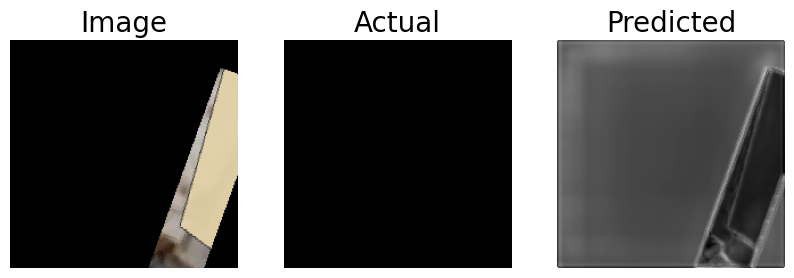

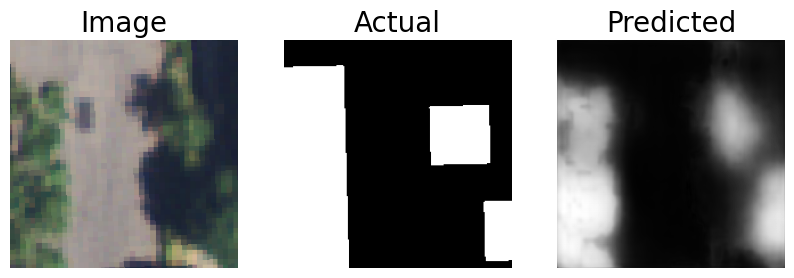

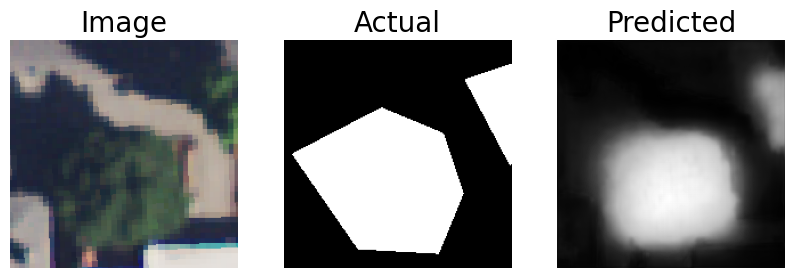

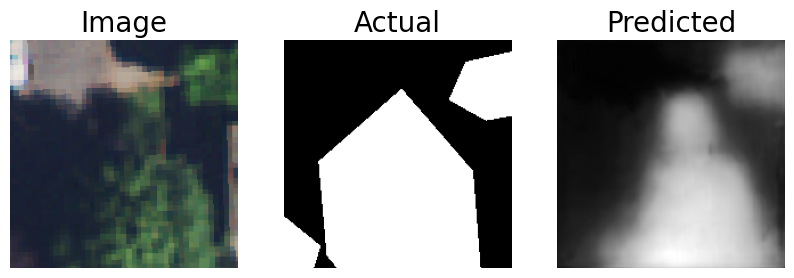

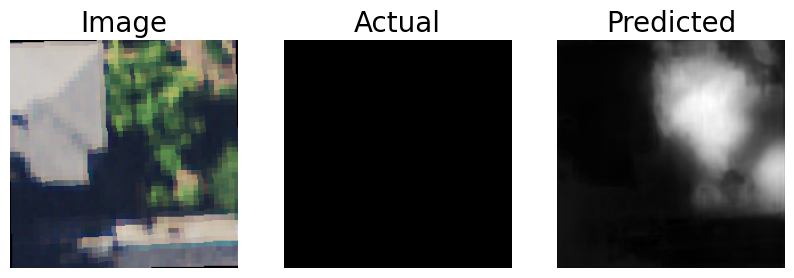

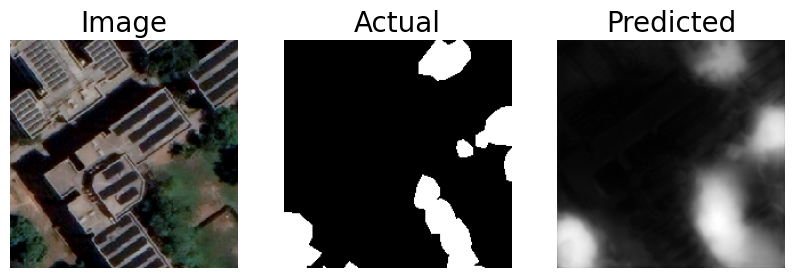

In [33]:
c = 6
for image, seg in dataloader:
    pred = model(image.to(DEVICE))
    pred = pred.cpu().detach()

    visualize(image=image[0], actual=seg[0], predicted=pred[0])
    c -= 1
    if c == 0:
        break


In [26]:
if SAVING:
    from uuid import uuid4
    hash = uuid4().hex
    torch.save(model, f"/content/drive/MyDrive/Colab Notebooks/models/Trees/UnetOnDatasetv4_{hash[:5]}.pth")

## Testing

In [27]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [28]:
len(test_dataloader) * BATCH_SIZE

2080

In [29]:
def test(model=model, dataloader=test_dataloader, device=DEVICE):
    
    model.eval() # Set model to evaluation mode
    running_loss = 0
    n_batch = 0
    with torch.no_grad():
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device, non_blocking=True) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device, non_blocking=True)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1

        epoch_loss = running_loss / n_batch

    print(f"Testing Loss {epoch_loss:.6f}")
    
    return epoch_loss

In [30]:
test_loss = test()

  0%|          | 0/65 [00:00<?, ?it/s]

Testing Loss 0.239569


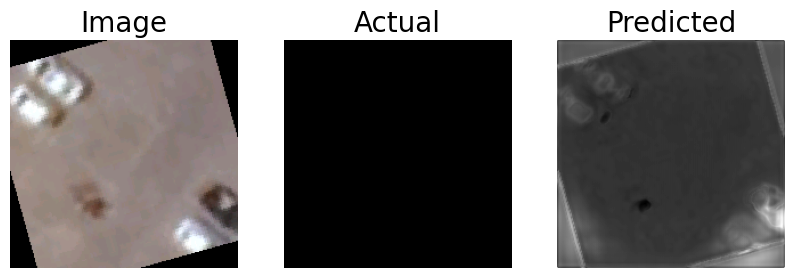

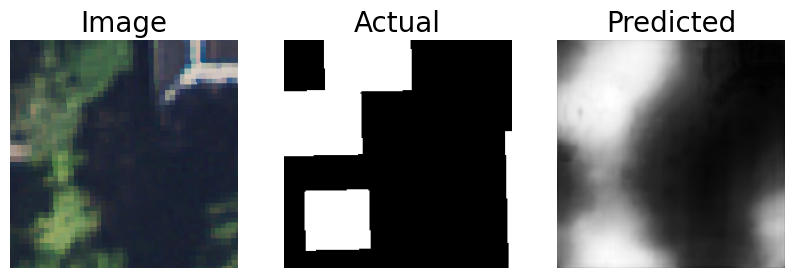

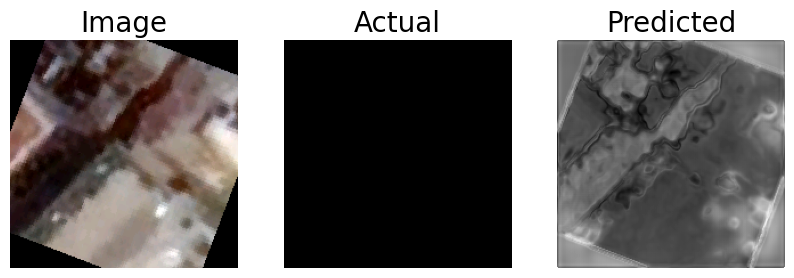

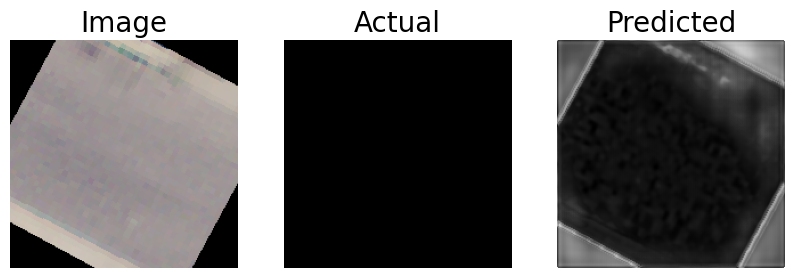

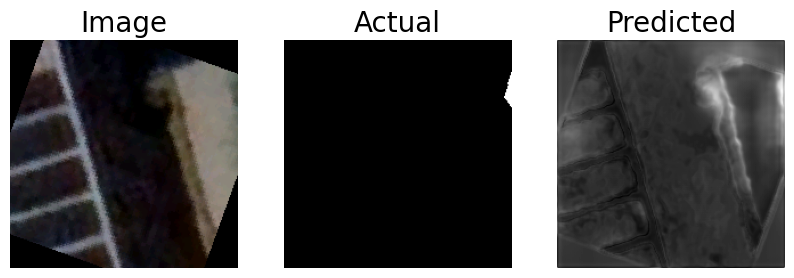

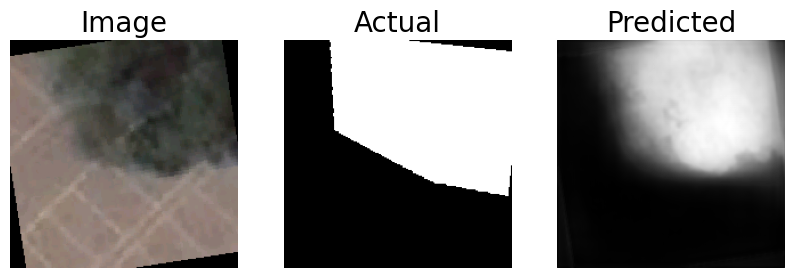

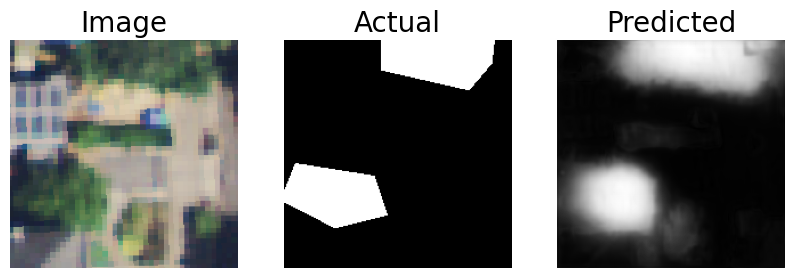

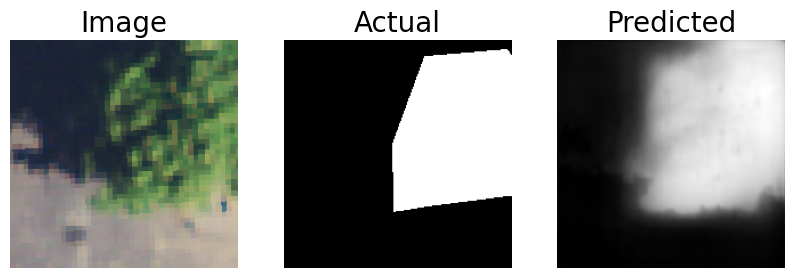

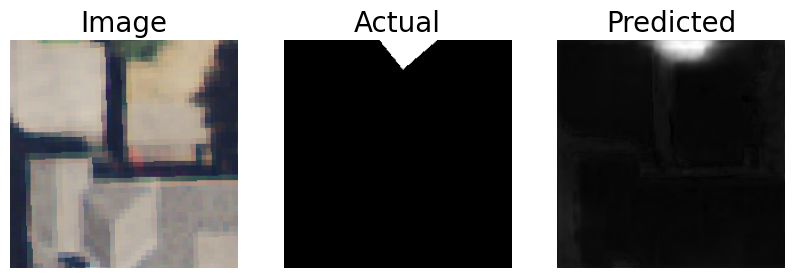

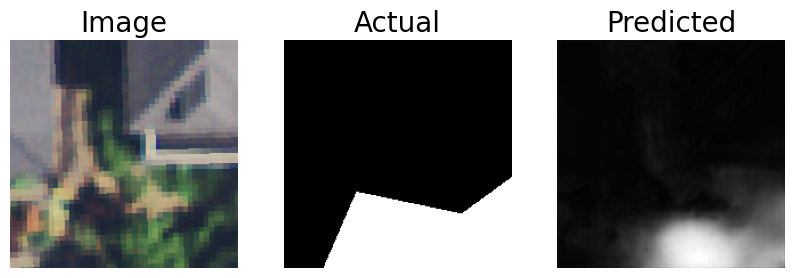

In [31]:
c = 10
for image, seg in test_dataloader:
    pred = model(image.to(DEVICE))
    pred = pred.cpu().detach()

    visualize(image=image[0], actual=seg[0], predicted=pred[0])
    c -= 1
    if c == 0:
        break